#Heart Disease (CVDS) Prediction

Dataset


*   This dataset is obtained from Kaggle: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction



In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

RANDOM_STATE = 55

In [3]:
#Load the dataset using pandas
df = pd.read_csv("/content/heart.csv")

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


One-hot encoding using Pandas

if possible, recommend to use variable with 3 or more values

In [5]:
hot_variables = ['Sex',
                'ChestPainType',
                'RestingECG',
                'ExerciseAngina',
                'ST_Slope'
                ]

In [6]:
df['Sex'].unique()

array(['M', 'F'], dtype=object)

One-hot encode variables with Pandas built-in method, pd.getdummies.

Among several arguments, the follwoing will be used to encode.

*   data: DataFrame to be used
* prefix: A list with prefixes, so we know which value we are dealing with
* columns: the list of columns that will be one-hot encoded. 'prefix' and 'columns' must have the same length.



In [7]:
#Replace the datagrame with on-hot encoded ones
df = pd.get_dummies(data = df,
                    prefix = hot_variables,
                    columns= hot_variables)

In [8]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True


Make a list of features but exclude 'HeartDisease' since that is what we will try to predict

In [9]:
features = [x for x in df.columns if x not in 'HeartDisease']

In [10]:
features

['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'Sex_F',
 'Sex_M',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'RestingECG_LVH',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up']

In [11]:
print(len(features))

20


Split the data into two groups
* training set
* validation set

In [12]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.

    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.

    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        com

In [13]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size=0.8, random_state = RANDOM_STATE)

In [14]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 734
validation samples: 184
target proportion: 0.5518


# Building Models

The model will be built using Scikitlearn

Among several hyperparameters, only these will be used in this case


The hyperparameters we will use and investigate here are:

* min_samples_split: The minimum number of samples required to split an internal node.

    ** Choosing a higher min_samples_split can reduce the number of splits and may help to reduce overfitting.
* max_depth: The maximum depth of the tree.

    **Choosing a lower max_depth can reduce the number of splits and may help to reduce overfitting.

In [15]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

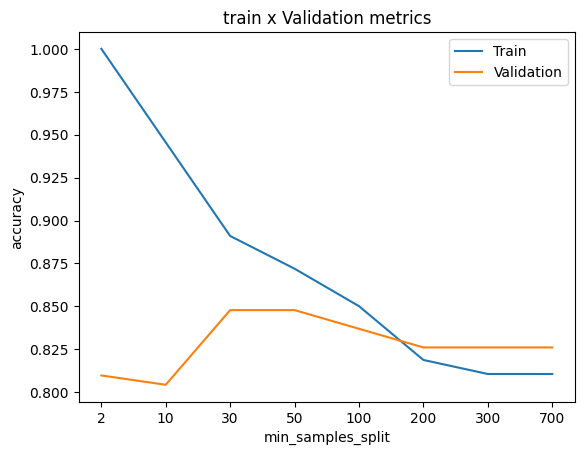

In [16]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
  model = DecisionTreeClassifier(min_samples_split= min_samples_split,
                                 random_state=RANDOM_STATE).fit(X_train, y_train)
  predictions_train = model.predict(X_train)
  predictions_val = model.predict(X_val)
  accuracy_train = accuracy_score(predictions_train, y_train)
  accuracy_val = accuracy_score(predictions_val, y_val)
  accuracy_list_train.append(accuracy_train)
  accuracy_list_val.append(accuracy_val)

plt.title("train x Validation metrics")
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.xticks(ticks = range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

#Test the max_depth's accuracy

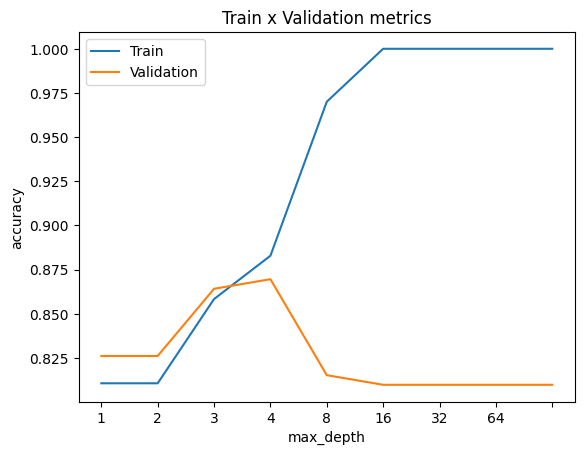

In [17]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

create the modest decision tree using the result from the previsous accuracy test.

In [18]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                              max_depth = 4,
                                              random_state = RANDOM_STATE).fit(X_train, y_train)

In [19]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8665
Metrics validation:
	Accuracy score: 0.8696


#Random  Forest

In [20]:
min_samples_split_list = [2, 10, 50, 100, 200, 300, 700]
max_depth_list = [2, 4, 9, 16, 32, 64, None]
n_estimators_list = [10, 50, 100, 500]

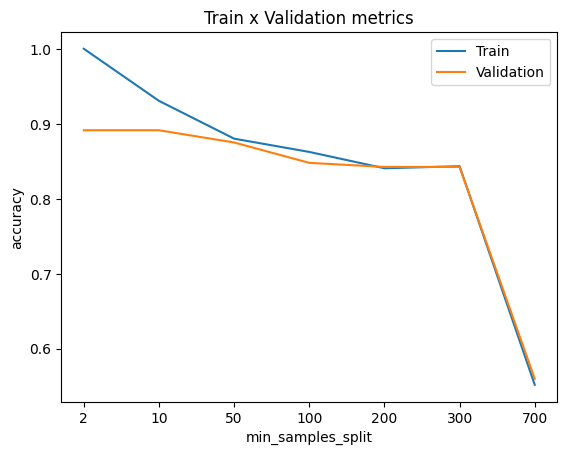

In [21]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
  model = RandomForestClassifier(min_samples_split = min_samples_split, random_state = RANDOM_STATE).fit(X_train, y_train)

  predictions_train = model.predict(X_train)
  predictions_val = model.predict(X_val)

  accuracy_train = accuracy_score(predictions_train, y_train)
  accuracy_val = accuracy_score(predictions_val, y_val)

  accuracy_list_train.append(accuracy_train)
  accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

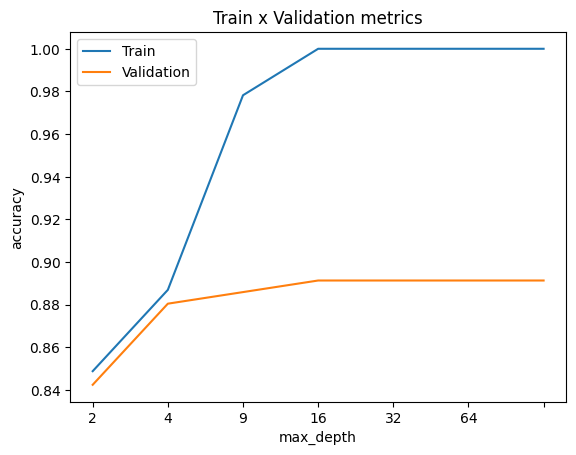

In [22]:
accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list:

    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train)
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)

    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)

    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

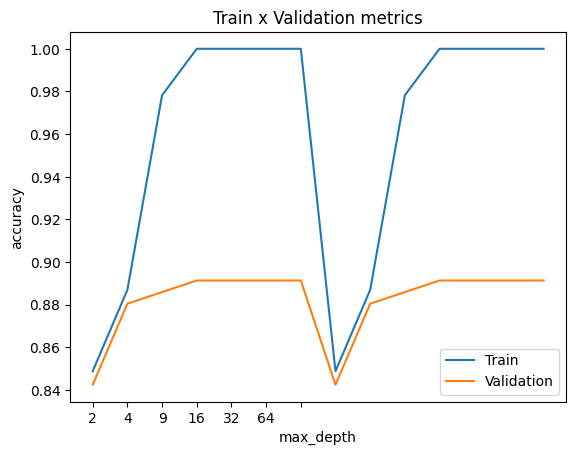

In [23]:
for max_depth in max_depth_list:

    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train)

    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)

    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)

    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

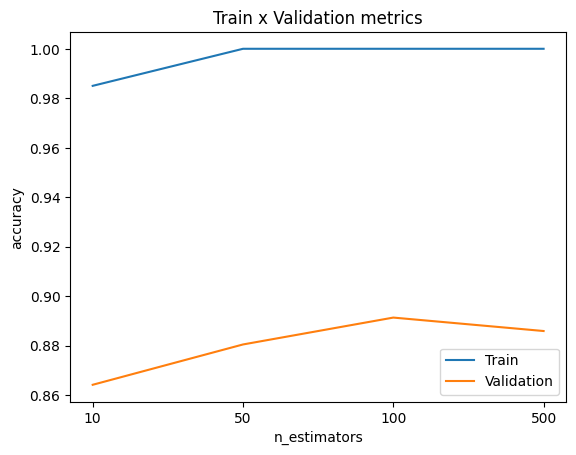

In [24]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [25]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 16,
                                             min_samples_split = 10).fit(X_train,y_train)

In [43]:
#Predict a single result
single_sample_from_train = X_train.iloc[[3]]

single_prediction_result = random_forest_model.predict(single_sample_from_train)

print(f"Prediction for the selected sample: {single_prediction_result[0]}")

if single_prediction_result[0] == 1:
    print("The model predicts this patient is POSITIVE for heart disease.")
else:
    print("The model predicts this patient is NEGATIVE for heart disease.")

Prediction for the selected sample: 0
The model predicts this patient is NEGATIVE for heart disease.


In [44]:
random_forest_model.predict(X_train)

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,

In [45]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9346
Metrics test:
	Accuracy score: 0.8859
